Processing file: SOAIc9ONdb4_captions.txt
Processing file: tjDZ9-6PxiQ_captions.txt
Processing file: T7O2EwCKjrE_captions.txt
Processing file: J7IGbrXZEZI_captions.txt
Processing file: oDw3zpHDS3w_captions.txt
Processing file: 8MWkMwNAZHo_captions.txt
Processing file: HcRh8IrwbCA_captions.txt
Processing file: Y2VvAiXtP_Y_captions.txt
Processing file: qMwRJXEZJ6k_captions.txt
Processing file: SLB72qmrusk_captions.txt
Processing file: yv8Bi2xcSK4_captions.txt
Processing file: xY6FZioxlgw_captions.txt
Processing file: HjElH_pDbU8_captions.txt
Processing file: gXm5OrH8lAA_captions.txt
Processing file: rMhh-T_3850_captions.txt
Processing file: BHR9ht4QVuM_captions.txt
Processing file: hrECwxk0Tvo_captions.txt
Processing file: 80oICq8QAew_captions.txt


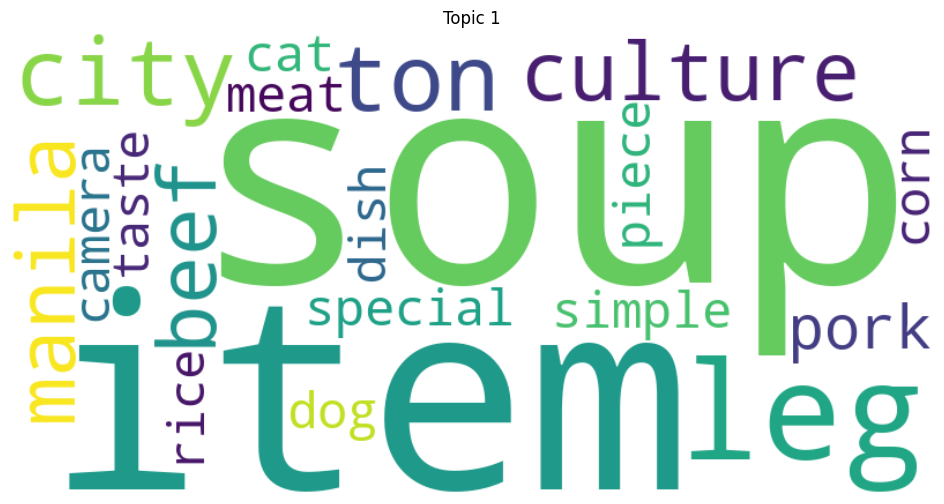

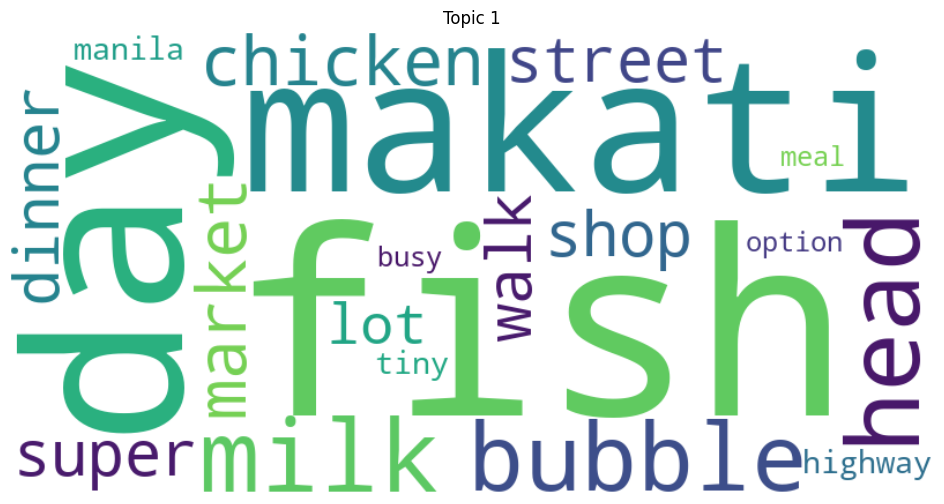

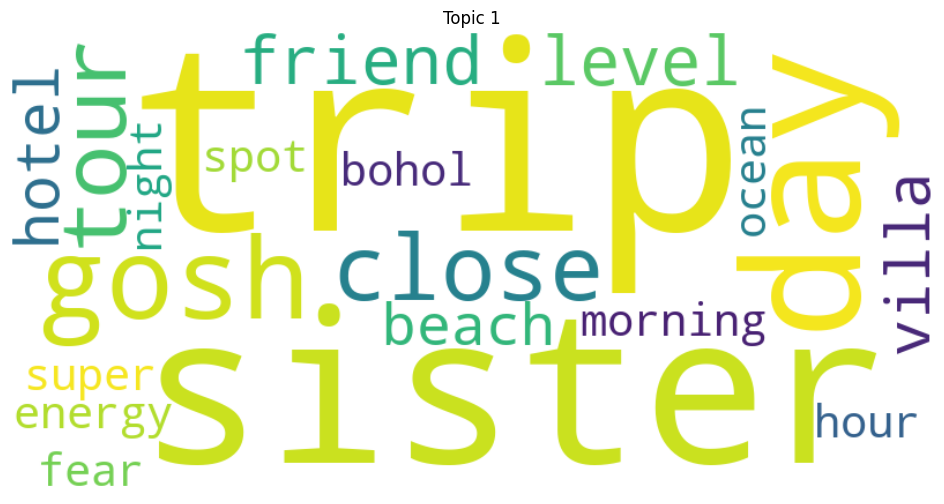

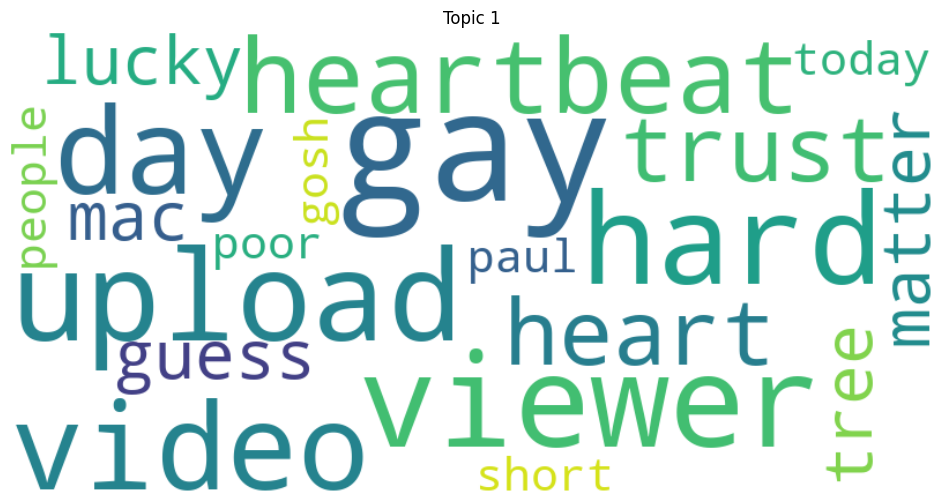

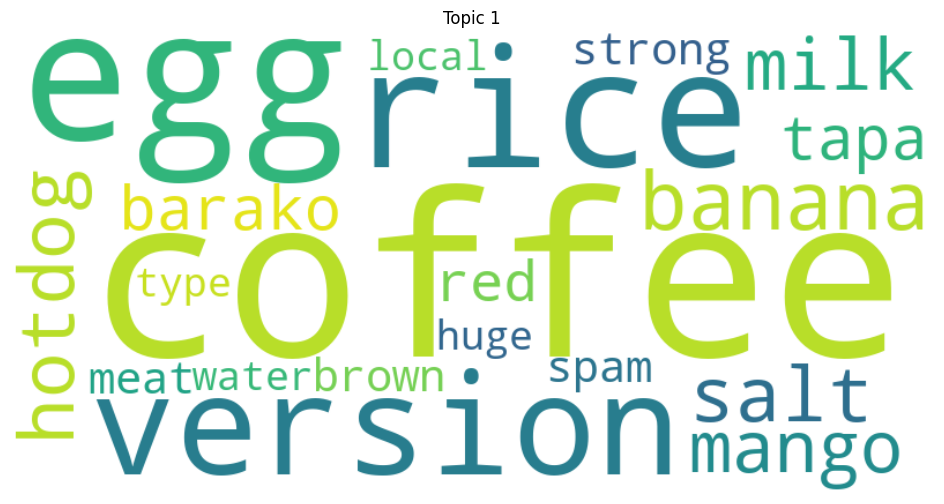

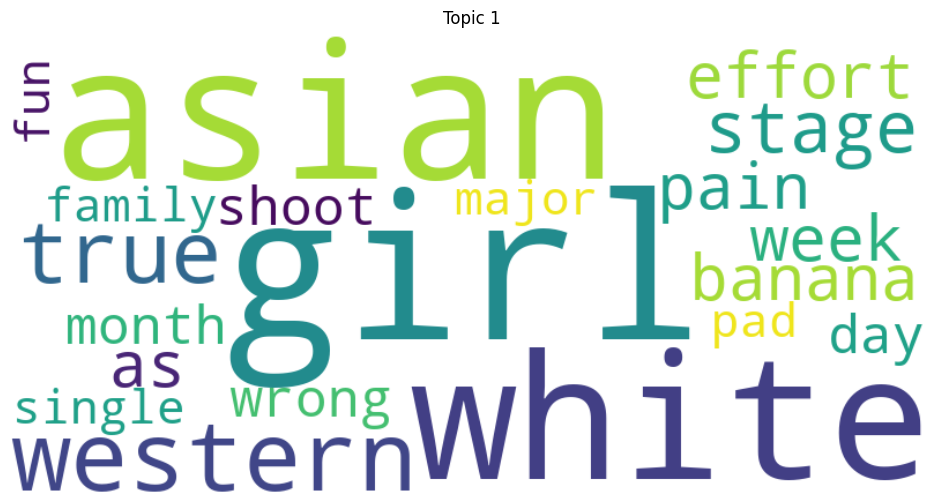

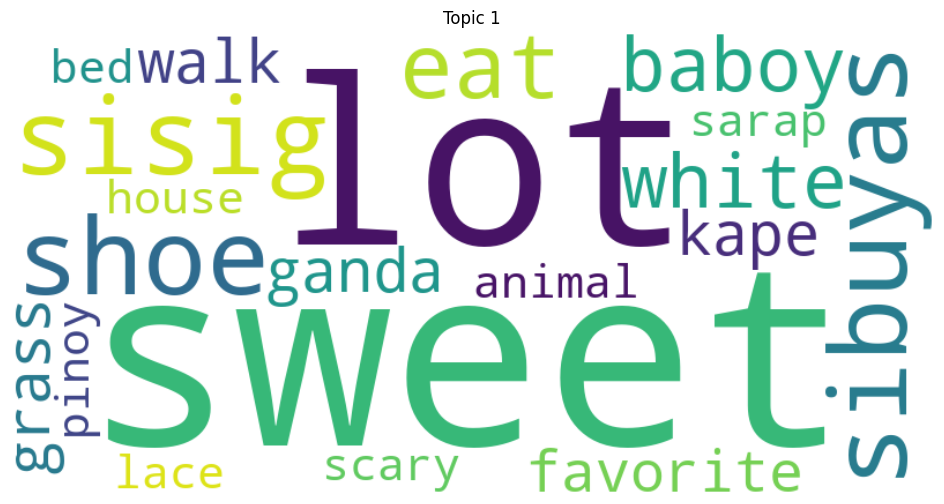

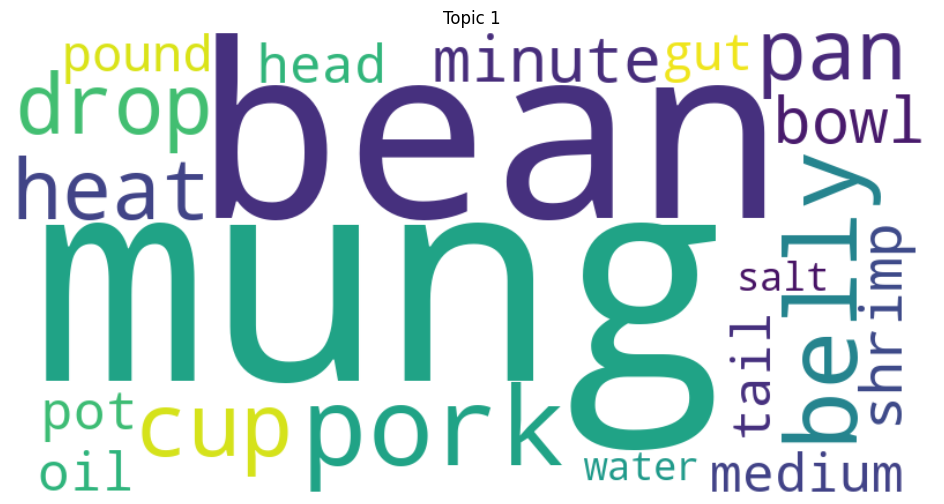

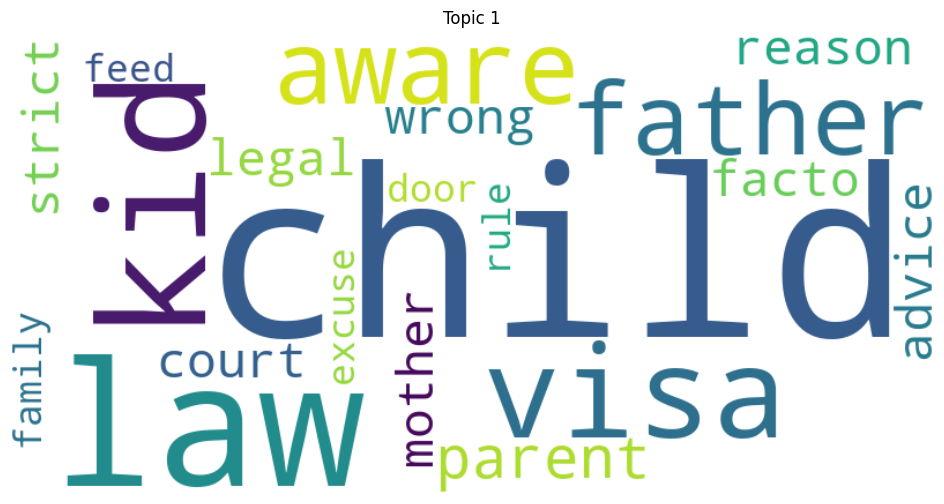

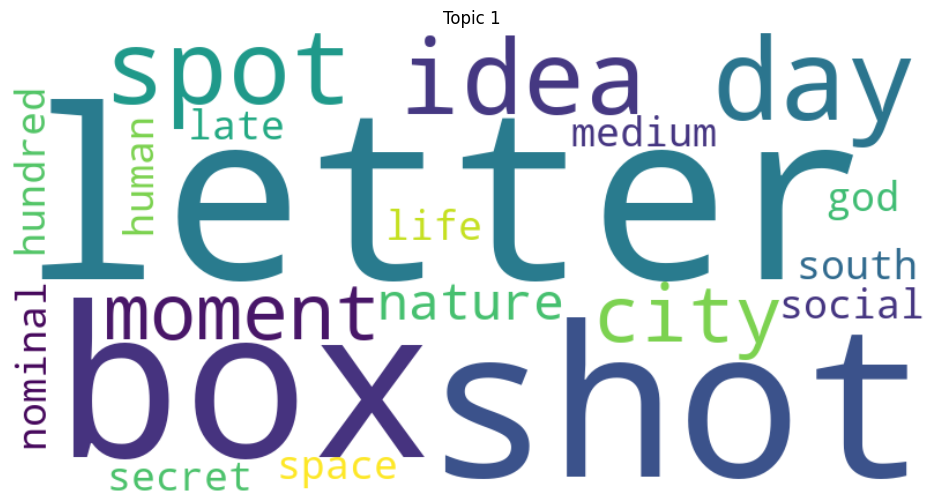

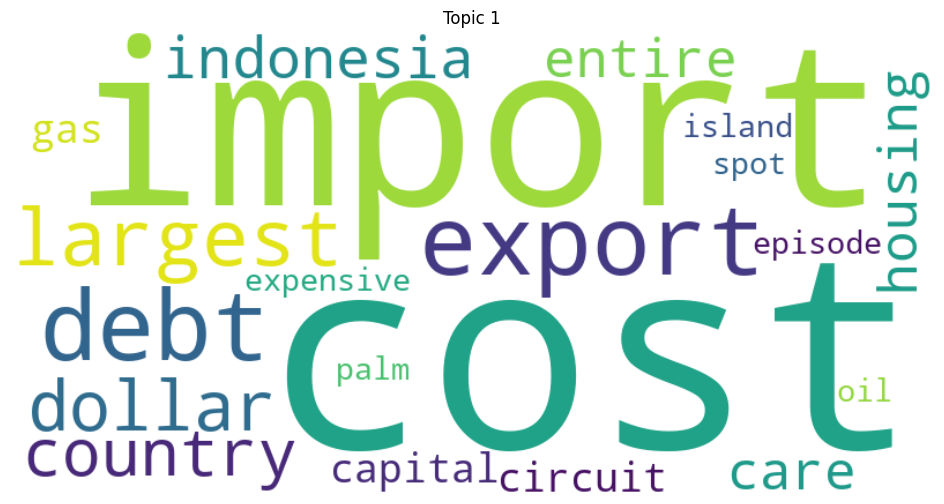

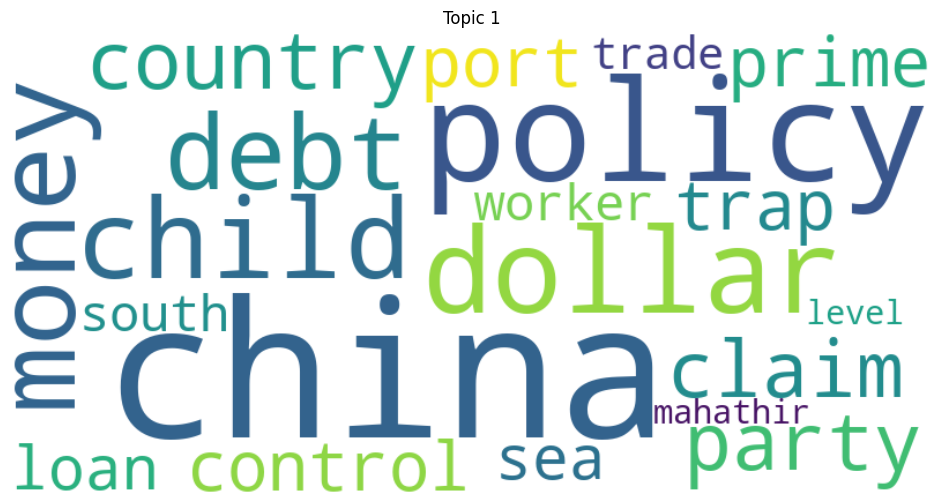

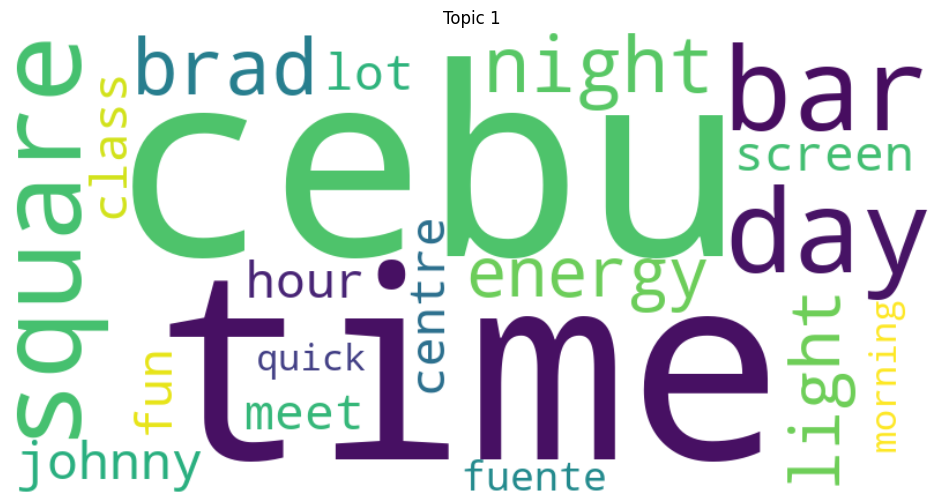

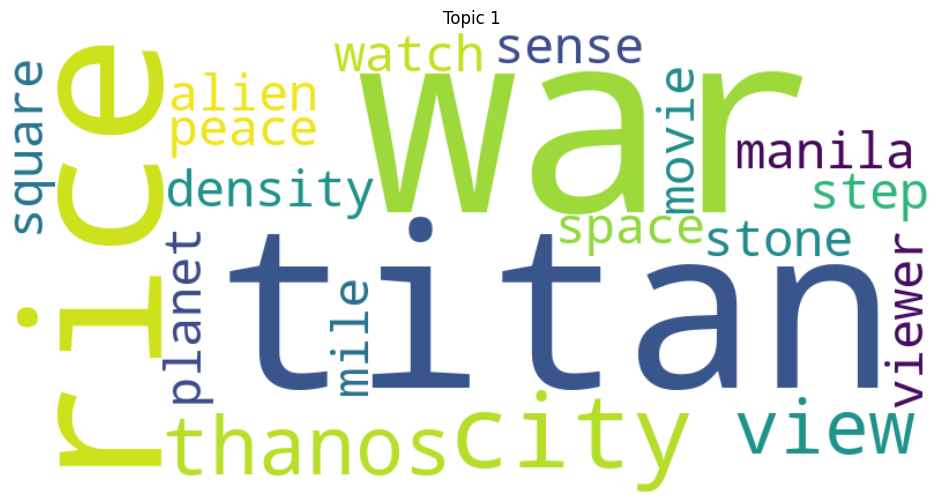

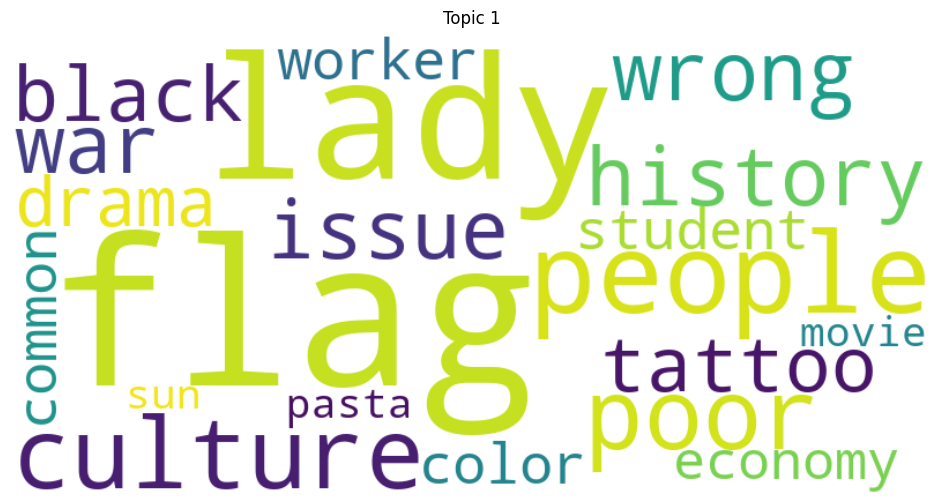

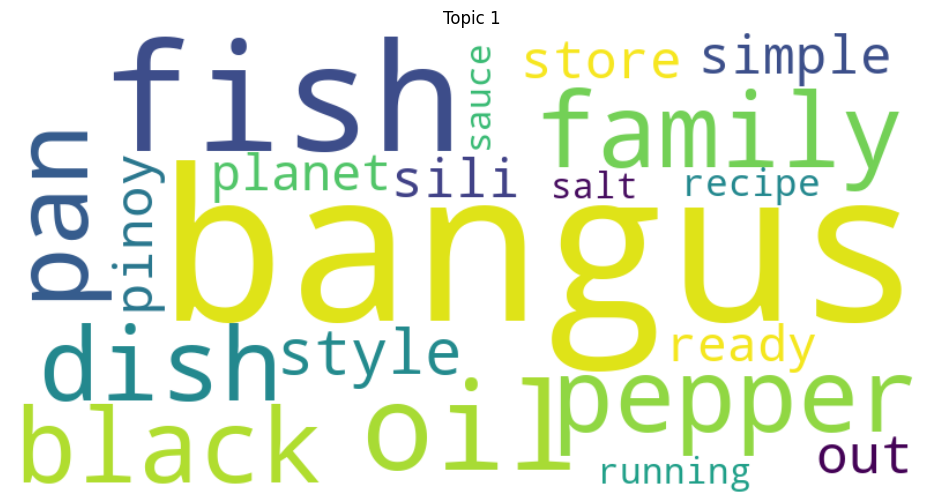

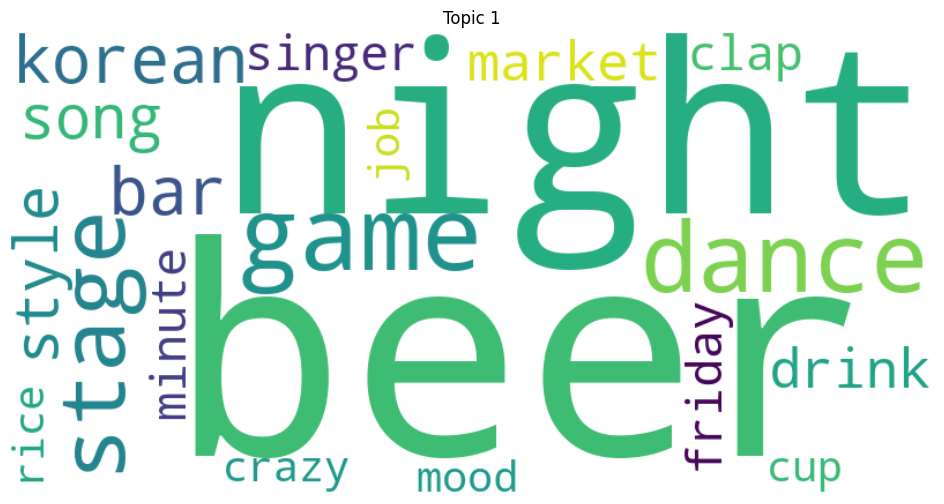

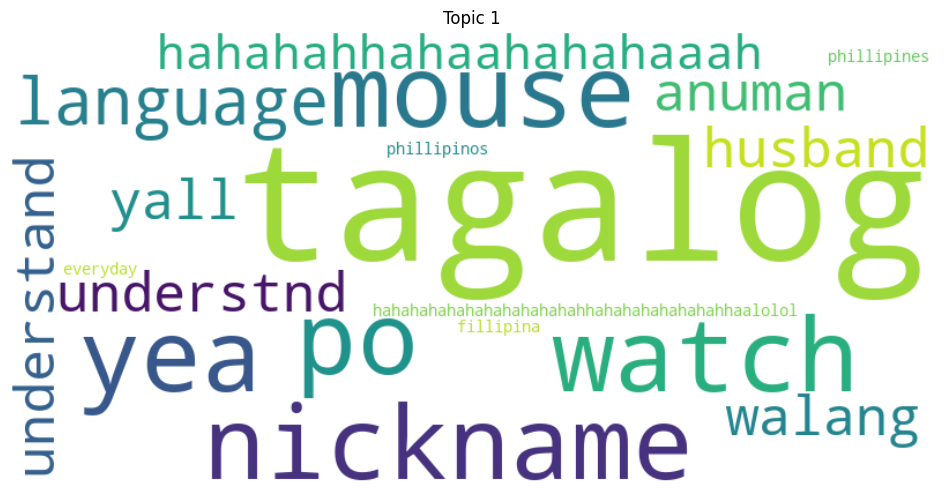

In [23]:
import os
import random
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import numpy as np
import spacy
import string
from wordcloud import WordCloud

# Using spacy.load() to load the Filipino FastText model
nlp = spacy.load("tl_fasttext_transition")  # Load the Filipino FastText model

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'

# Function to load random documents
def load_random_documents(folder_path, sample_size=20):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()
            if len(content.split()) >= 100:
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

documents, file_names = load_random_documents(transcripts_folder_path)

# Function to load video tags
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()
    return video_tags

video_tags = load_video_tags(tags_folder_path)

# Fetch stopwords
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    return set(response.text.splitlines())

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'successful', 'perfectly', 'yeap', 
    'wondering', 'fantastic', 'hurry', 'german', 'age', 'country', 'subscribing', 'bluesy', 'jump', 'pretty', 'understanding', 'personalized',
    'and', 'the', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'up', 'about', 'over', 'into', 'through', 'between', 'under', 'against', 'all',
    'you', 'haha', 'hahaha', 'ha', 'hey', 'bye', 'hello', 'hi', 'oh', 'blah', 'easy'
]
stop_words.update(custom_stop_words, kpop_keywords, broad_terms, more_keywords, github_stopwords)

lemmatizer = WordNetLemmatizer()

# Identify Filipino words using SpaCy model
def is_filipino_word(word):
    # Process the word using SpaCy
    doc = nlp(word)
    # Use the word vector from SpaCy to determine if it's a Filipino word
    embedding = doc.vector
    return np.linalg.norm(embedding) > 0.70  # This threshold might need adjustment

# Function to filter and weight Filipino words
def preprocess_text_with_tags(doc, video_id, tag_weight=4, filipino_weight=5):
    # Convert the entire document to lowercase to ensure uniformity
    doc = doc.lower()

    # Remove punctuation from the document
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the document into words
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)
    
    # Filter out verbs, adjectives, and adverbs based on their POS tags
    filtered_tokens = [
        lemmatizer.lemmatize(word) for word, pos in tokens_with_pos 
        if word.isalpha() and word not in stop_words 
        and pos not in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    ]
    
    weighted_tokens = []
    for token in filtered_tokens:
        if is_filipino_word(token):
            weighted_tokens.extend([token] * filipino_weight)
        else:
            weighted_tokens.append(token)

    # Check if there are tags associated with the video and add them to the tokens
    if video_id in video_tags:
        tags = video_tags[video_id]
        for tag in tags:
            if is_filipino_word(tag):
                weighted_tokens.extend([tag] * tag_weight * filipino_weight)
            else:
                weighted_tokens.extend([tag] * tag_weight)

    return ' '.join(weighted_tokens)
# LDA topic modeling
lda_models = []
topic_vectors = []

for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")

    preprocessed_doc = preprocess_text_with_tags(doc, video_id)

    if len(preprocessed_doc) > 0:
        dictionary = corpora.Dictionary([preprocessed_doc.split()])
        corpus = [dictionary.doc2bow(preprocessed_doc.split())]

        lda_model = LdaModel(corpus, num_topics=1, id2word=dictionary, passes=50, random_state=42)
        lda_models.append(lda_model)

        topic_distribution = lda_model.get_document_topics(corpus[0], minimum_probability=0)
        topic_vector = [prob for _, prob in topic_distribution]
        topic_vectors.append(topic_vector)

# Function to generate WordCloud for each topic
def generate_wordcloud_for_topic(lda_model, num_words=20):
    topics = lda_model.show_topics(num_words=num_words, formatted=False)
    
    for t, words in topics:
        word_freq = {word[0]: word[1] for word in words}  # Extract words and their probabilities
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
        
        # Plot the word cloud for the topic
        plt.figure(figsize=(20, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {t+1}")
        plt.show()

# Generate and display word clouds for each topic in all LDA models
for lda_model in lda_models:
    generate_wordcloud_for_topic(lda_model)

In [15]:
print(len(stop_words))

1439
